## D5n MODIS Unbalanced dataset 25k 2013 - 2019  min 25 class, 1,2 class weight - Model training and validation:
This model will use data obtained from MODIS (one day only), NDWI, NDWI_ICE, DEM SLOPE and EUCLIDEAN_NORM to predict water and non-water features. For all years

#### 0. Load required libraries, site dependant constants and utility functions.

In [1]:
from os import listdir
from os.path import isfile, join
from lightgbm.sklearn import LGBMClassifier
import numpy as np
import seaborn as sns
import datetime
from sklearn import metrics
import joblib
# EOLearn libraries:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, LoadTask, SaveTask, FeatureType, EOExecutor
from eolearn.core import OverwritePermission

# Add to python path parent dictionary
import sys
sys.path.append("../../")

# load site dependant constants (HERE YOU CAN CHOOSE DIFFERENT LOCATION)
from aoi_sites import upe_promice_area as site

# load utility functions
from utils import io_functions as io_utils
from utils import plot_functions as plot_utils

#### 1. Load sampled eopatches:

In [2]:
# pick dataset_name
input_dataset_file_name = '_sptl_smpl_25k_pr_pic_ref_1_2_min_wat_25/'

dataset_filepath_2013 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10{}'.format(input_dataset_file_name)
dataset_filepath_2014 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2014_05-2014_10{}'.format(input_dataset_file_name)
dataset_filepath_2015 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2015_05-2015_10{}'.format(input_dataset_file_name)
dataset_filepath_2016 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2016_05-2016_10{}'.format(input_dataset_file_name)
dataset_filepath_2017 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2017_05-2017_10{}'.format(input_dataset_file_name)
dataset_filepath_2018 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2018_05-2018_10{}'.format(input_dataset_file_name)
dataset_filepath_2019 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10{}'.format(input_dataset_file_name)

dataset_path_list = [dataset_filepath_2013,
                dataset_filepath_2014,
                dataset_filepath_2015,
                dataset_filepath_2016,
                dataset_filepath_2017,
                dataset_filepath_2018,
                dataset_filepath_2019]

#### 2. Choose test eopatches

In [3]:
#list_of_available_patches_2013 = io_utils.get_list_of_eopatches(dataset_filepath_2013)

#test_eppatches_chosen_names = np.random.choice(list_of_available_patches_2013, 7, replace=True)
#test_eppatches_chosen_names

test_eppatches_chosen_names = np.array(['2974_maxcc_0.05_x-3_y-135', '2976_maxcc_0.05_x-3_y-137',
       '3179_maxcc_0.05_x-5_y-137', '3067_maxcc_0.05_x-4_y-138',
       '3180_maxcc_0.05_x-5_y-138', '3473_maxcc_0.05_x-7_y-134',
       '2975_maxcc_0.05_x-3_y-136'], dtype='<U25')


In [4]:
%%time
train_eopatches= []
test_eopatches= []
train_eopatches_filenames = []
test_eopatches_filenames = []

for eopatches_filepath in dataset_path_list:

    list_of_available_patches = io_utils.get_list_of_eopatches(eopatches_filepath)
    list_in_chunks = io_utils.chunkIt(list_of_available_patches, 2 ) # number of chunks- 1 bc all can go
    for chunk in list_in_chunks:
        #print('Doing now following eopatches:', chunk )
        for eopatch_name in chunk:
            if eopatch_name in test_eppatches_chosen_names:
                test_eopatches_filenames.append(eopatches_filepath+eopatch_name)
                test_eopatches.append(EOPatch.load(eopatches_filepath+eopatch_name, lazy_loading=True))
                
            else:
                train_eopatches_filenames.append(eopatches_filepath+eopatch_name)
                train_eopatches.append(EOPatch.load(eopatches_filepath+eopatch_name, lazy_loading=True))    
print(len(train_eopatches))
print(len(test_eopatches))

228
48
Wall time: 5.57 s


In [5]:
# check if all eopatches from all years are there. 
test_eopatches_filenames[:10]

['../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10_sptl_smpl_25k_pr_pic_ref_1_2_min_wat_25/2974_maxcc_0.05_x-3_y-135',
 '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10_sptl_smpl_25k_pr_pic_ref_1_2_min_wat_25/2975_maxcc_0.05_x-3_y-136',
 '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10_sptl_smpl_25k_pr_pic_ref_1_2_min_wat_25/2976_maxcc_0.05_x-3_y-137',
 '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10_sptl_smpl_25k_pr_pic_ref_1_2_min_wat_25/3067_maxcc_0.05_x-4_y-138',
 '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10_sptl_smpl_25k_pr_pic_ref_1_2_min_wat_25/3179_maxcc_0.05_x-5_y-137',
 '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10_sptl_smpl_25k_pr_pic_ref_1_2_min_wat_25/3180_maxcc_0.05_x-5_y-138',
 '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10_sptl_smpl_25k_pr_pic_ref_1_2_min_wat_25/3473_maxcc_0.05_x-7_y-134',
 '../../data/EOPatches/LANDSAT_8/UPE_PROM

In [6]:
eo_patch = io_utils.load_exemplary_eopatch_from_file(file ='../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10{}'.format(input_dataset_file_name))
eo_patch

Loaded from ../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10_sptl_smpl_25k_pr_pic_ref_1_2_min_wat_25/3470_maxcc_0.05_x-7_y-131


EOPatch(
  data: {
    DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED: numpy.ndarray(shape=(9, 25000, 1, 13), dtype=float32)
  }
  mask: {
    WATER_MASK_ST_025_SAMPLED: numpy.ndarray(shape=(9, 25000, 1, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    DEM_RAW_AVG: 1472.7562
    DEM_RAW_MAX: 1616.0
    DEM_RAW_MED: 1483.0
    DEM_RAW_MIN: 1301.0
    DEM_RAW_STD: 72.84604
    DEM_RAW_VAR: 5306.546
    index_x: 7
    index_y: 131
    maxcc: '0.05'
    patch_index: 3470
    service_type: 'wcs'
    site_name: 'UPE_PROMICE'
    size_x: '30m'
    size_y: '30m'
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2019-05-01', '2019-10-31')
  }
  bbox: BBox(((440000.0, 8040000.0), (450000.0, 8050000.0)), crs=EPSG:32622)
  timestamp: [datetime.datetime(2019, 6, 11, 15, 24, 20), ..., datetime.datetime(2019, 10, 1, 15, 24, 53)], length=9
)

####  3. Fetch and organise dataset

In [7]:
# Definition of the train and test patch IDs

# Set the features and the labels for train and test sets
features_train = np.array([eopatch.data['DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED'] for eopatch in train_eopatches if eopatch.data['DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED'].size > 0])
#features_train (number_of_patches,(time,width,height, bands))
labels_train = np.array([eopatch.mask['WATER_MASK_ST_025_SAMPLED'] for eopatch in train_eopatches if eopatch.mask['WATER_MASK_ST_025_SAMPLED'].size > 0])
#features_train (number_of_patches,(time,width,height, answer=True, False))
features_test = np.array([eopatch.data['DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED'] for eopatch in test_eopatches if eopatch.data['DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED'].size > 0 ])
labels_test = np.array([eopatch.mask['WATER_MASK_ST_025_SAMPLED'] for eopatch in test_eopatches if eopatch.mask['WATER_MASK_ST_025_SAMPLED'].size > 0])

In [8]:
#reshape to  (number_of_patches x time, width, height, bands)
features_train_stacked = np.vstack(features_train)
labels_train_stacked = np.vstack(labels_train)
features_test_stacked = np.vstack(features_test)
labels_test_stacked = np.vstack(labels_test)

# get shape
p_train_x_time, w, h, b = features_train_stacked.shape
p_test_x_time, w, h, b = features_test_stacked.shape


# reshape to n x m
#n - no of observation
#m - no of features, - bands in my case, misssing DEM

features_train = features_train_stacked.reshape(p_train_x_time * w * h, b)
labels_train = labels_train_stacked.reshape(p_train_x_time * w * h, 1)
features_test = features_test_stacked.reshape(p_test_x_time * w * h, b)
labels_test = labels_test_stacked.reshape(p_test_x_time * w * h, 1)


#@TODO
# remove points with no reference from training (so we dont train to recognize "no data")
# interpolation????
#mask_train = labels_train == 0
#features_train = features_train[~mask_train]
#labels_train = labels_train[~mask_train]

# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
#mask_test = labels_test == 0
#features_test = features_test[~mask_test]
#labels_test = labels_test[~mask_test]


####  5. Pickle dataset

In [9]:
#import pickle

#dataset = [features_train, labels_train, features_test, labels_test ]
#dataset_name = 'dataset_2013_05-2019_10_sptl_smpl_80k_pr_patch_balanced_classes_1_2_min_25_test_7_test_fixed'

#with open('{}.pickle'.format(dataset_name), 'wb') as output:
#    pickle.dump(dataset, output)

####  4. Data statistics

In [10]:
#to compare old data distribution (little less )

print('TRAIN DATA:')
tot_obs = np.size(labels_train)
print('Total observations: ', tot_obs )

tot_wat = np.count_nonzero(labels_train)
print('Total water count', tot_wat )

ratio_wat_vs_non_wat = tot_wat/ tot_obs
print('Percent of water feature among data:', ratio_wat_vs_non_wat )

print('\nTEST DATA:')

tot_obs = np.size(labels_test)
print('Total observations: ', tot_obs )

tot_wat = np.count_nonzero(labels_test)
print('Total water count', tot_wat )

ratio_wat_vs_non_wat = tot_wat/ tot_obs
print('Percent of water feature among data:', ratio_wat_vs_non_wat )
# dataset is half of the previous one!!!

sample_pos_weight = (tot_obs - tot_wat ) / tot_wat
print(sample_pos_weight)

TRAIN DATA:
Total observations:  40400000
Total water count 7797958
Percent of water feature among data: 0.19301876237623763

TEST DATA:
Total observations:  9300000
Total water count 1621182
Percent of water feature among data: 0.1743206451612903
4.7365551801093275


In [11]:
sample_pos_weight = 2

####  4. Model training

In [12]:
%%time

# Set up training classes
labels_unique = np.unique(labels_train)

# Set up the model
model = LGBMClassifier(boosting='gbdt',
    objective='binary',
    learning_rate=0.1,
    metric='mse', #mae: mean absolute error mse: mean squared error
    #scale_pos_weight= sample_pos_weight, # add a weight to the positive class examples.
    # this can account for highly skewed data.
    #class_weight= 'balanced' 
    lambda_l1   = 0.5, # L1 regularization.
    lambda_l2   = 0.5, # L2 regularization.
    max_bin = 1000,
    max_depth = 6,
    num_leaves = 26
            
)

# train the model
model.fit(features_train, labels_train.squeeze())


Wall time: 2min 19s


LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, importance_type='split', lambda_l1=0.5,
               lambda_l2=0.5, learning_rate=0.1, max_bin=1000, max_depth=6,
               metric='mse', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=28,
               objective='binary', random_state=None, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

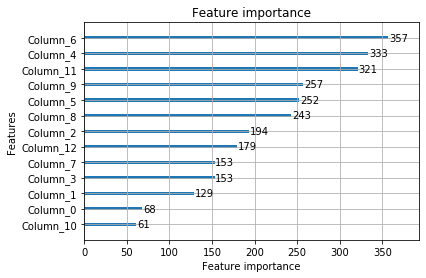

In [13]:
import lightgbm as lgb
_ = lgb.plot_importance(model)

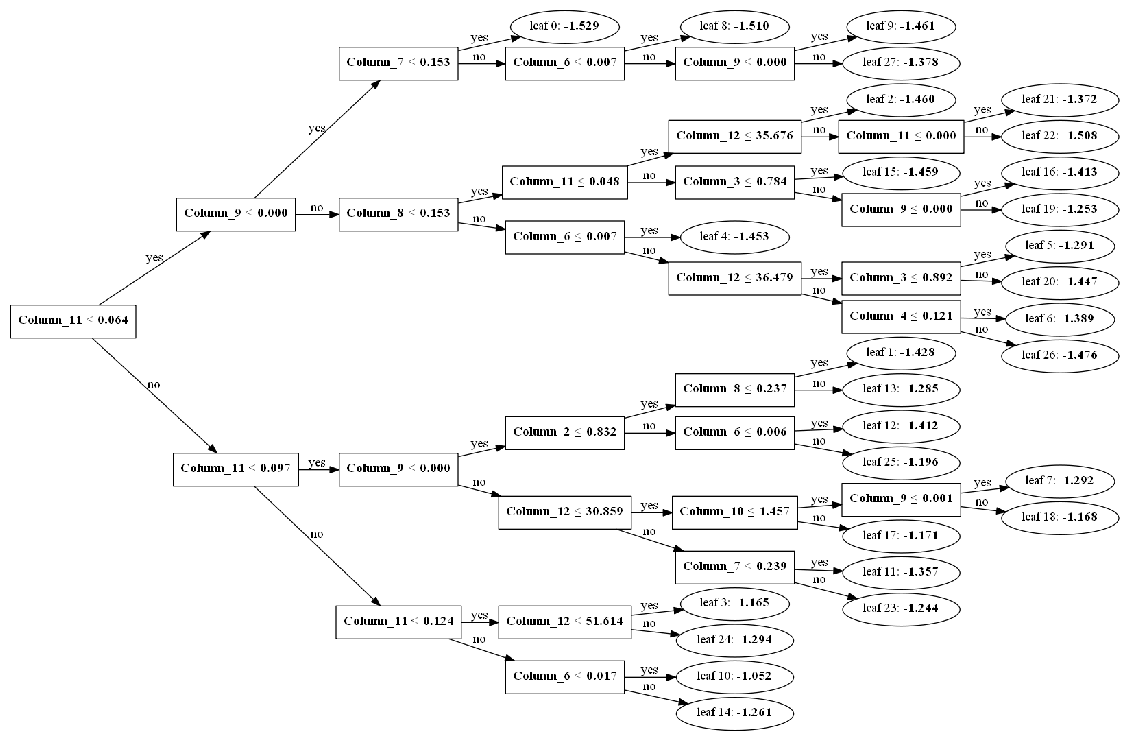

In [14]:
_ = lgb.plot_tree(model, figsize=(20, 20))

In [15]:
# uncomment to save the model
model_base_name = 'NEW_model_25k_unbalanced_WATER_only_MODIS_test_7_fixed_lr_01_min_wat_25'
joblib.dump(model, './{}.pkl'.format(model_base_name))

['./NEW_model_25k_unbalanced_WATER_only_MODIS_test_7_fixed_lr_01_min_wat_25.pkl']

####  5. Model Validation

In [16]:
print('TEST:')
# predict the test labels
plabels_test = model.predict(features_test)
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_test, plabels_test)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_test, plabels_test, average='weighted')))

# predict the train labels
plabels_train = model.predict(features_train)
print('TRAIN:')
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_train, plabels_train)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_train, plabels_train, average='weighted')))

TEST:
Classification accuracy 84.9%
Classification F1-score 82.4%
TRAIN:
Classification accuracy 85.2%
Classification F1-score 83.4%


In [17]:
actual_water = np.count_nonzero(labels_test)
predicted_water = np.count_nonzero(plabels_test)

print('Water Test data size:',actual_water)

tp = np.count_nonzero(np.logical_and(labels_test.squeeze(), plabels_test.squeeze()))
print('Water True positive:', tp, 'and recall', 100* tp /actual_water, 'and precision:', tp /predicted_water)


Water Test data size: 1621182
Water True positive: 465266 and recall 28.69918368202953 and precision: 0.6490197035745423


In [18]:
class_labels = np.unique(labels_test)
print(class_labels)
class_names = ['non-water', 'water']
class_names

[False  True]


['non-water', 'water']

In [19]:

f1_scores = metrics.f1_score(labels_test, plabels_test, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test, plabels_test, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test, plabels_test, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f}% |  {2:2.1f}%  | {3:2.1f}%'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------


C:\Users\Kamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  import sys


         * non-water            = 91.3% |  96.7%  | 86.5%
         * water                = 39.8% |  28.7%  | 64.9%


#### 6. Plot the standard and transposed Confusion Matrix:

In [20]:
import itertools
import matplotlib.pyplot as plt
# Define the plotting function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, ylabel='True label', xlabel='Predicted label', filename=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=2, suppress=True)
    
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + np.finfo(np.float).eps)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    plt.title(title, fontsize=20)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)

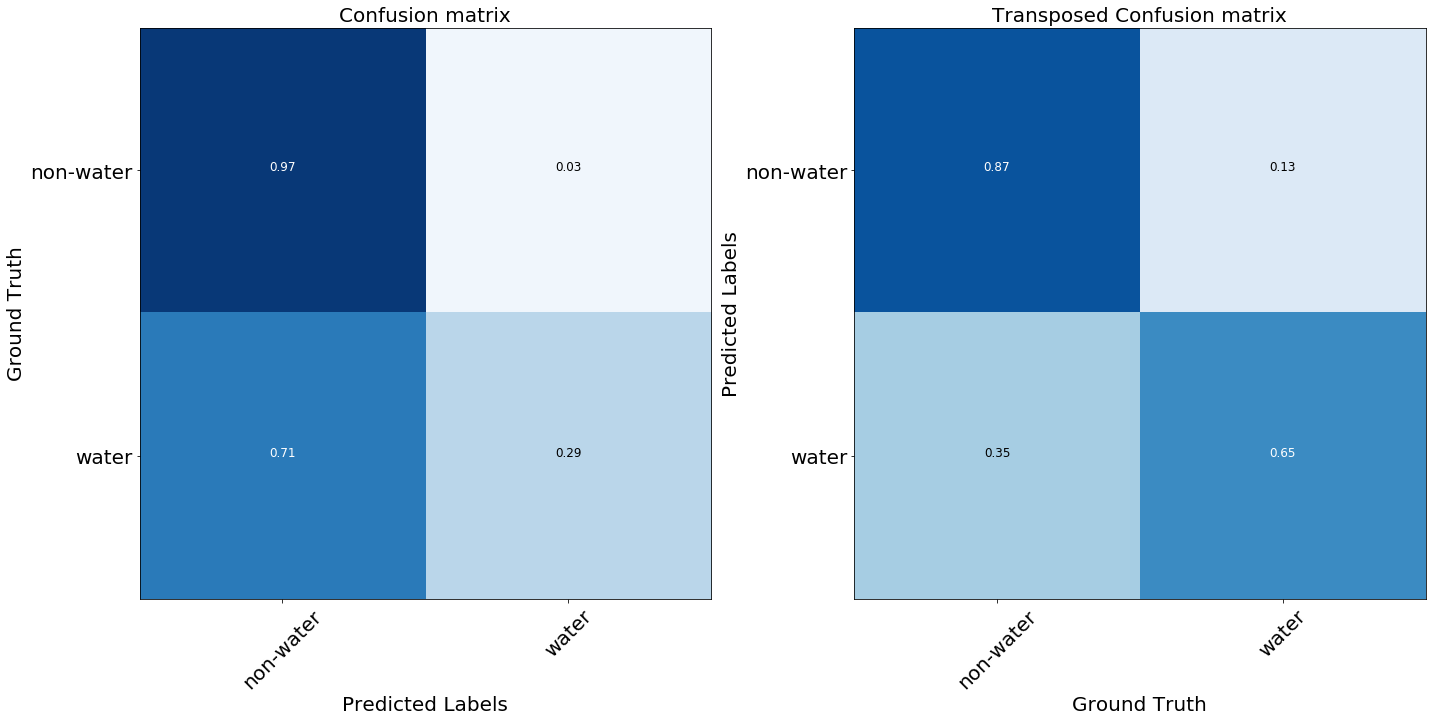

In [21]:
ig = plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
conf_matrix_gbm = metrics.confusion_matrix(labels_test, plabels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      ylabel='Ground Truth', 
                      xlabel='Predicted Labels',
                      title='Confusion matrix');

plt.subplot(1, 2, 2)
conf_matrix_gbm = metrics.confusion_matrix(plabels_test, labels_test)
plot_confusion_matrix(conf_matrix_gbm, 
                      classes=[name for idx, name in enumerate(class_names) if idx in class_labels], 
                      normalize=True, 
                      xlabel='Ground Truth', 
                      ylabel='Predicted Labels',
                      title='Transposed Confusion matrix');

plt.tight_layout()

#### 7. Plot dataset balance

C:\Users\Kamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  


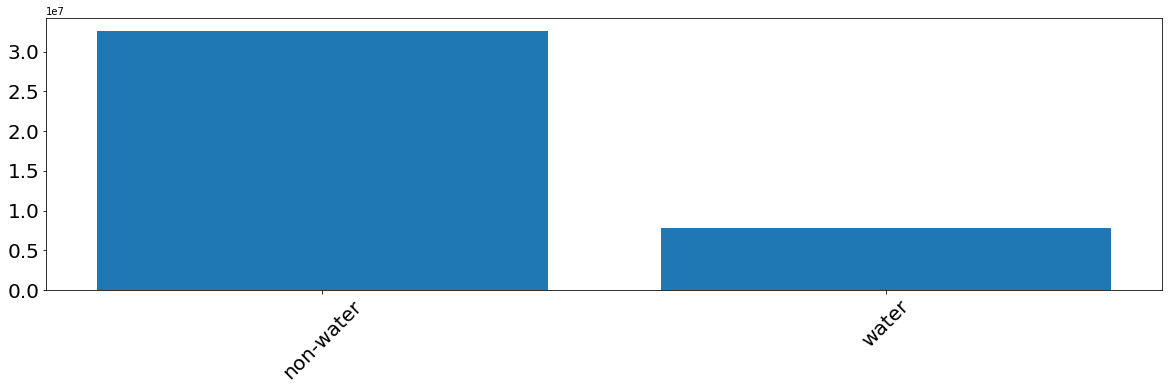

In [22]:
fig = plt.figure(figsize=(20, 5))

label_ids, label_counts = np.unique(labels_train, return_counts=True)

plt.bar(range(len(label_ids)), label_counts)
plt.xticks(range(len(label_ids)), [class_names[i] for i in label_ids], rotation=45, fontsize=20);
plt.yticks(fontsize=20);

#### 8. ROC curves and AUC metrics
Calculate precision and recall rates, draw ROC curves and calculate AUC.

In [23]:
class_labels_zero_one = 1*class_labels
l_one_zero = 1*labels_test
l_one_zero.shape

(9300000, 1)

In [24]:
from sklearn import preprocessing
scores_test = model.predict_proba(features_test)

labels_binarized = preprocessing.label_binarize((1*labels_test).tolist(), classes=[0, 1, 3])
labels_binarized.shape

(9300000, 3)

In [25]:

fpr = dict()
tpr = dict()
roc_auc = dict()

for idx,lbl in enumerate([1, 2]):
    fpr[idx], tpr[idx], _ = metrics.roc_curve(labels_binarized[:, idx], scores_test[:, idx])
    roc_auc[idx] = metrics.auc(fpr[idx], tpr[idx])

C:\Users\Kamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  import sys


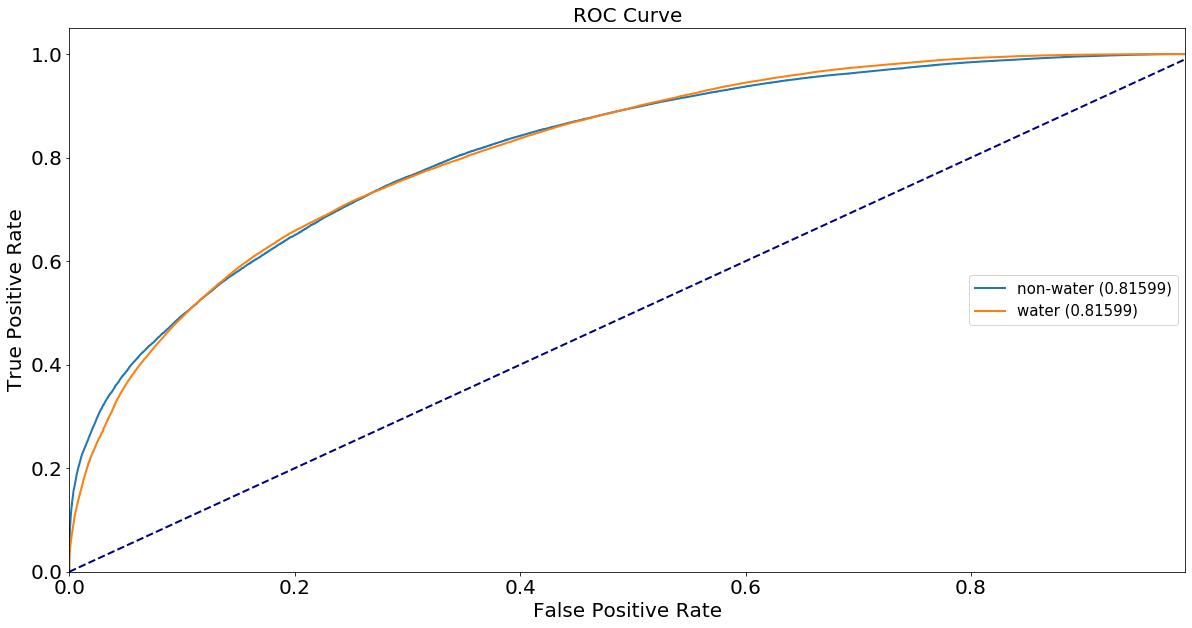

In [26]:
plt.figure(figsize=(20, 10))

for idx,lbl in enumerate(class_labels):
    if np.isnan(roc_auc[idx]):
        continue
    plt.plot(fpr[idx], tpr[idx],
         lw=2, label=class_names[lbl] + ' (%0.5f)' % roc_auc[idx])
    

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 0.99])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('ROC Curve', fontsize=20)
plt.legend(loc="center right", prop={'size': 15})
plt.show()

#### 9. Most important features:
Let us now check which features are most important in the above classification. The LightGBM model already contains the information about feature importances, so we only need to query them.

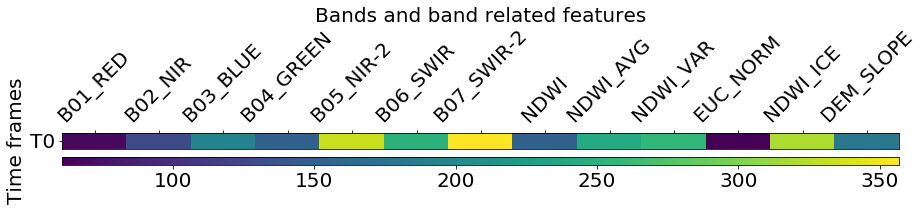

In [27]:
# names of features
fnames = ['B01_RED', 'B02_NIR', 'B03_BLUE', 'B04_GREEN', 'B05_NIR-2', 'B06_SWIR', 'B07_SWIR-2', 'NDWI', 'NDWI_AVG','NDWI_VAR', 'EUC_NORM','NDWI_ICE', 'DEM_SLOPE', ]

# get feature importances and reshape them to dates and features
z = model.feature_importances_.reshape((1, b))

fig = plt.figure(figsize=(15, 15))
ax = plt.gca()

# plot the importances
im = ax.imshow(z, aspect=0.25)
plt.xticks(range(len(fnames)), fnames, rotation=45, fontsize=20)
plt.yticks(range(1), ['T{}'.format(i) for i in range(1)], fontsize=20)
plt.xlabel('Bands and band related features', fontsize=20)
plt.ylabel('Time frames', fontsize=20)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

# cax = fig.add_axes([0.82, 0.125, 0.04, 0.755]) 
# plt.colorbar(im, cax=cax)

fig.subplots_adjust(wspace=0, hspace=0)

cb = fig.colorbar(im, ax=[ax], orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)

In [28]:
model.feature_importances_

array([ 68, 129, 194, 153, 333, 252, 357, 153, 243, 257,  61, 321, 179])

#### 10. Visualization of the results

In [29]:
class PredictPatch(EOTask):
    """
    Task to make model predictions on a patch. Provide the model and the feature, 
    and the output names of labels and scores (optional)
    """
    def __init__(self, model, features_feature, predicted_labels_name, predicted_scores_name=None):
        self.model = model
        self.features_feature = features_feature
        self.predicted_labels_name = predicted_labels_name
        self.predicted_scores_name = predicted_scores_name
        
    def execute(self, eopatch):
        ftrs = eopatch[self.features_feature[0]][self.features_feature[1]]
        
        t, w, h, f = ftrs.shape
        ftrs = ftrs.reshape(t * w * h, f)
        
        plabels = self.model.predict(ftrs)
        plabels = plabels.reshape(t, w, h )
        plabels = plabels[..., np.newaxis]
        #eopatch.add_feature(FeatureType.MASK_TIMELESS, self.predicted_labels_name, plabels)
        
        if self.predicted_scores_name:
            pscores = self.model.predict_proba(ftrs)
            _, d = pscores.shape
            pscores = pscores.reshape(w, h, d)
            eopatch.add_feature(FeatureType.DATA_TIMELESS, self.predicted_scores_name, pscores)
        
        return plabels

In [30]:
eo_patch = io_utils.load_exemplary_eopatch_from_file(file='../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10/',  patch_id=6, random_choice=True)
eo_patch

Loaded from ../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10/3470_maxcc_0.05_x-7_y-131


EOPatch(
  data: {
    DATASET_CLD_200_dil_6_str2: numpy.ndarray(shape=(29, 333, 333, 11), dtype=float32)
    DATASET_RAW_NDWI_NRB_19_NORM_SLOPE: numpy.ndarray(shape=(29, 333, 333, 13), dtype=float32)
    LANDSAT_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(29, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI: numpy.ndarray(shape=(29, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_GREEN_NIR: numpy.ndarray(shape=(29, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_ICE: numpy.ndarray(shape=(29, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_1: numpy.ndarray(shape=(29, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_2: numpy.ndarray(shape=(29, 333, 333, 1), dtype=float32)
    LANDSAT_QA_LAYERS: numpy.ndarray(shape=(29, 333, 333, 5), dtype=float32)
    LANDSAT_RAW_BANDS: numpy.ndarray(shape=(29, 333, 333, 11), dtype=float32)
    MODIS_AVG_NBR_19: numpy.ndarray(shape=(29, 333, 333, 1), dtype=float32)
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(29, 333, 333, 1), dtype=float32)
  

In [31]:
# TASK FOR PREDICTION
predict_patch = PredictPatch(model, (FeatureType.DATA, 'DATASET_RAW_NDWI_NRB_19_NORM_SLOPE'), 'WATER_MASK_ST_025')

predictions = []
predictions.append(predict_patch.execute(eo_patch))

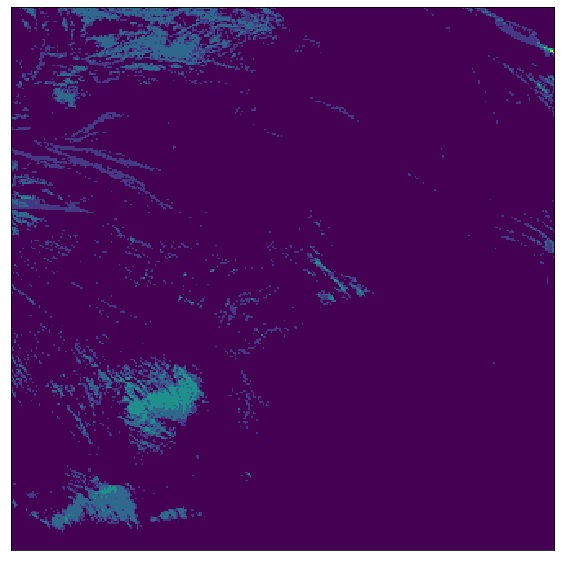

In [32]:
plot_utils.plot_timeless_mask_LANDSAT_8(eo_patch, band_idx=0, mask_acces_name='WATER_MASK_ST_025_COUNT' )

2019-07-13 15:24:28
Ploting...


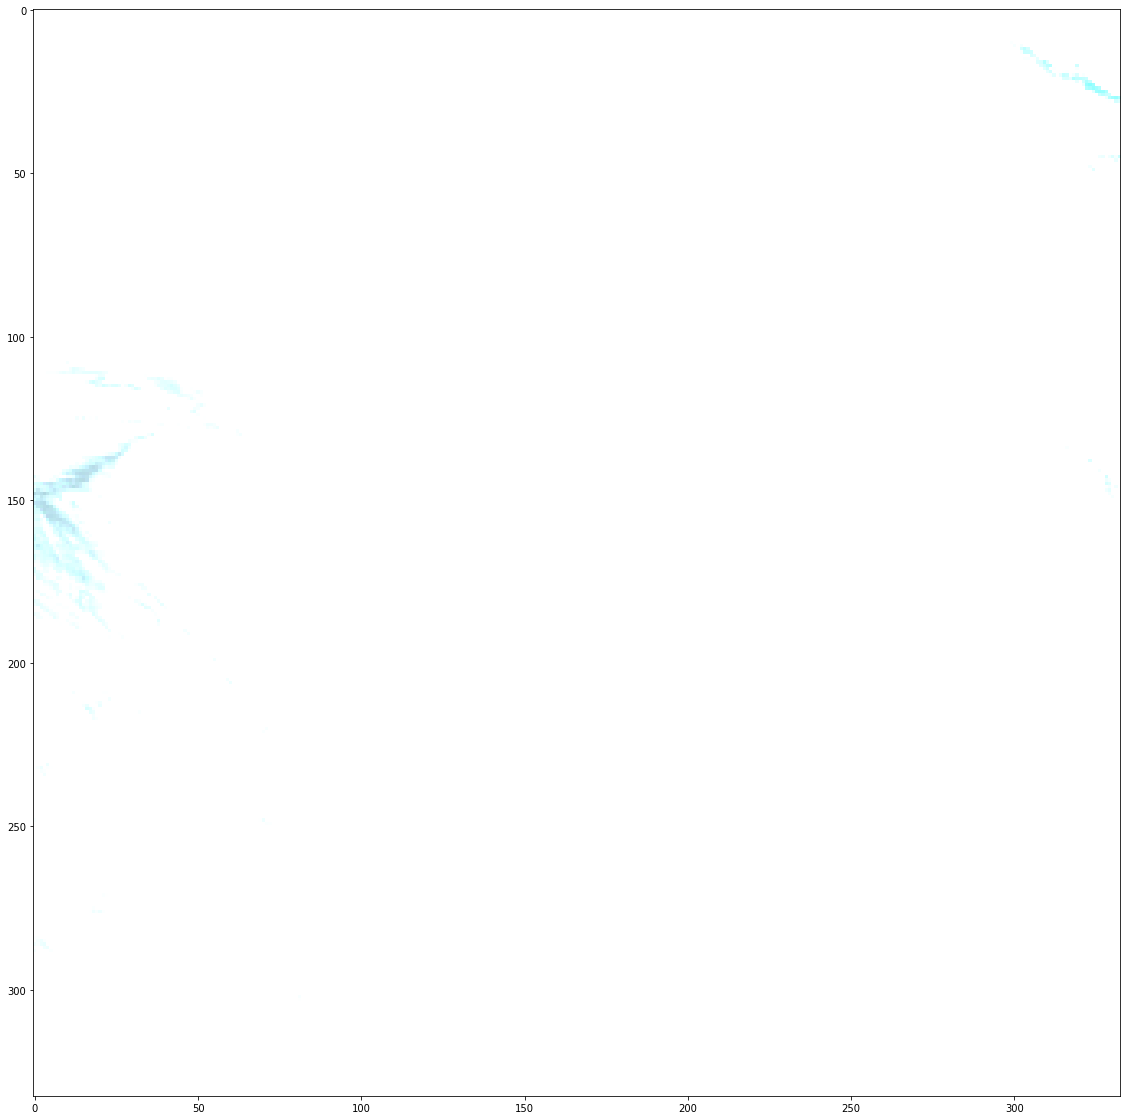

In [33]:
plot_utils.plot_RGB_LANDSAT_8_image(eo_patch, datetime_idx=15 )

2019-07-13 15:24:28
Ploting...


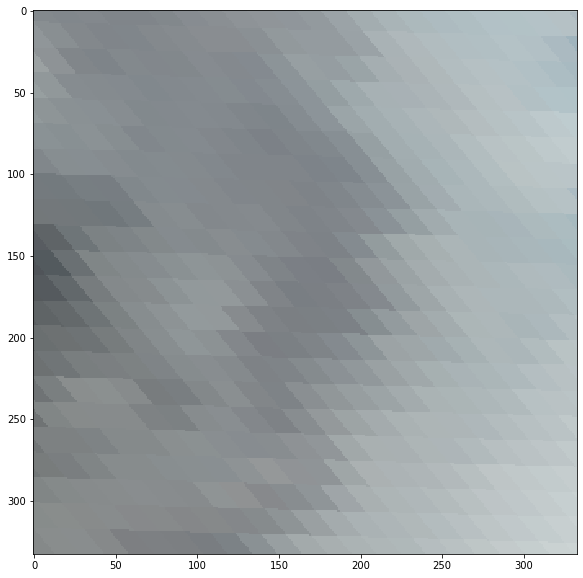

In [34]:
plot_utils.plot_RGB_MODIS_image(eo_patch, data_acces_name='MODIS_RAW_BANDS_DAY_0', datetime_idx=15)

In [35]:
patch_no = 15
reference_patch = eo_patch.mask['WATER_MASK_ST_025'][patch_no]
inspected_patch = predictions[0][patch_no]

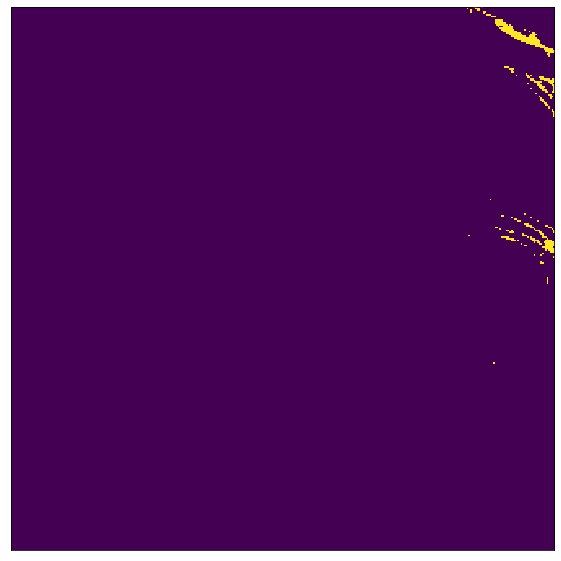

In [36]:
plot_utils.plot_matrix(reference_patch)

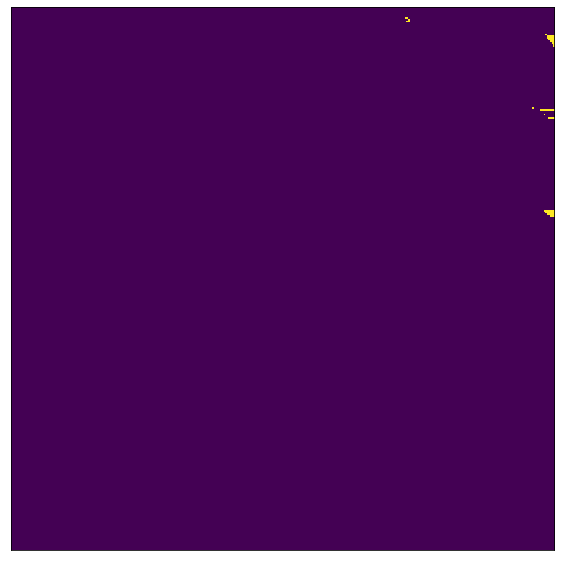

In [37]:
plot_utils.plot_matrix(inspected_patch)

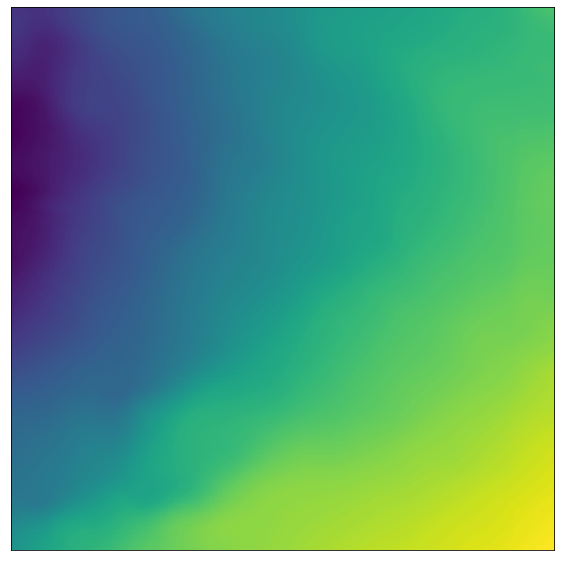

In [38]:
plot_utils.plot_matrix(eo_patch.data_timeless['DEM_RAW_LAYER'].squeeze())

2019-07-13 15:24:28
Band: 0
Band: 1
Band: 2
Band: 3
Band: 4
Band: 5
Band: 6
Band: 7
Band: 8
Band: 9
Band: 10
Band: 11
Band: 12


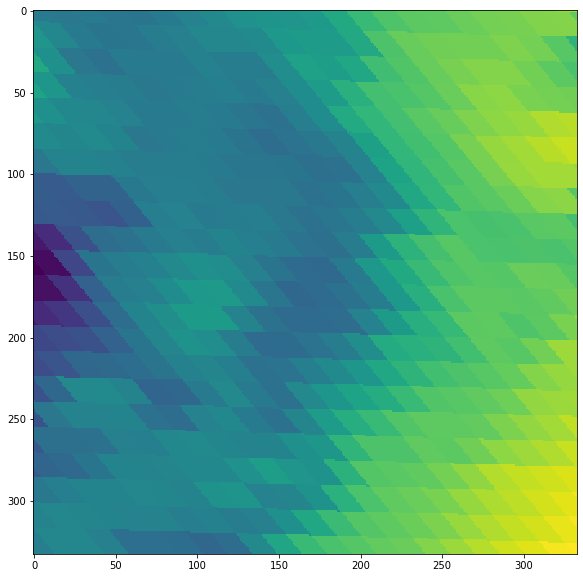

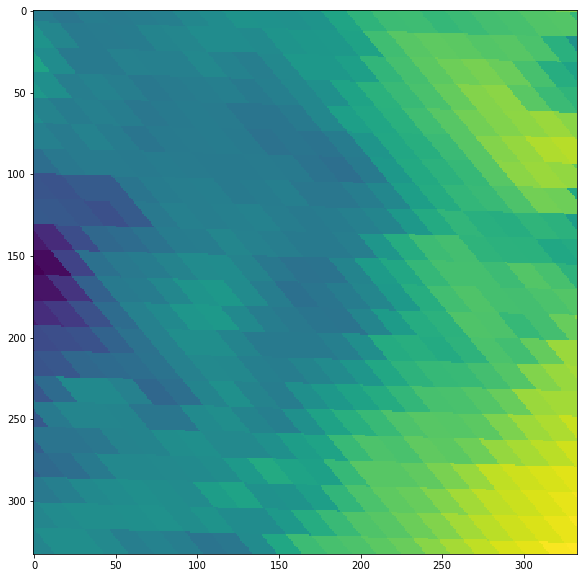

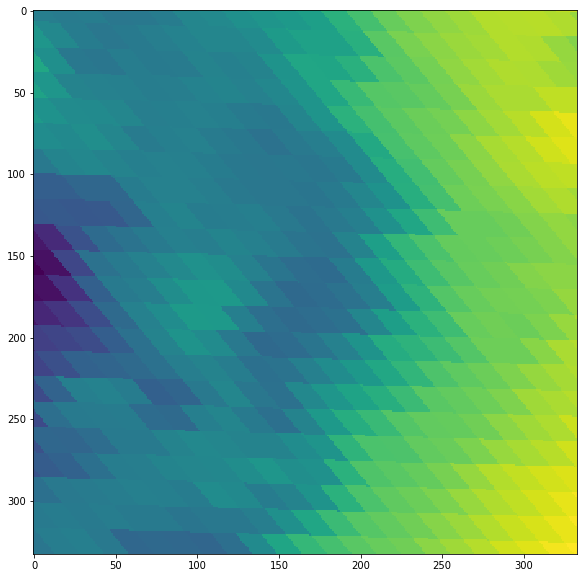

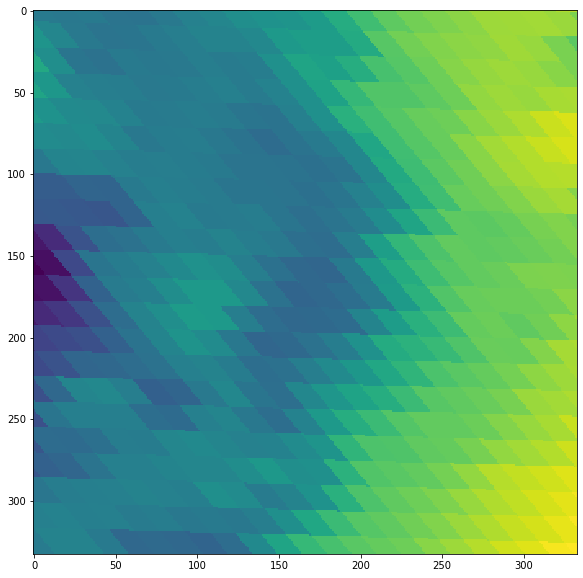

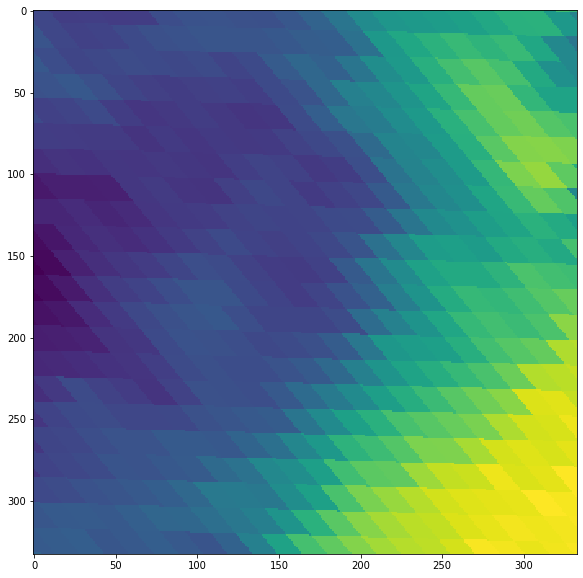

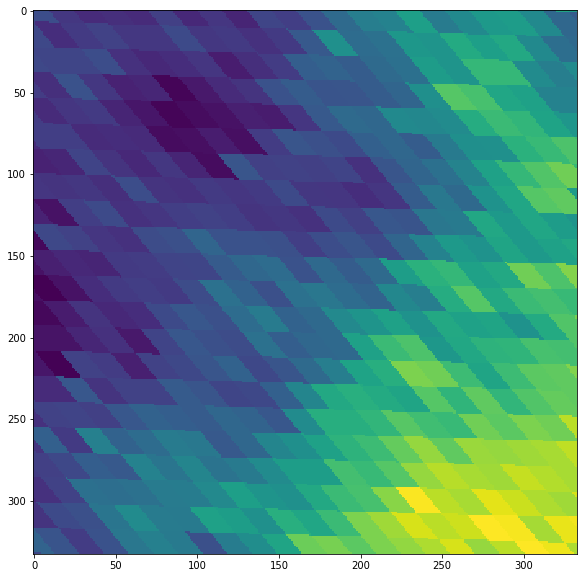

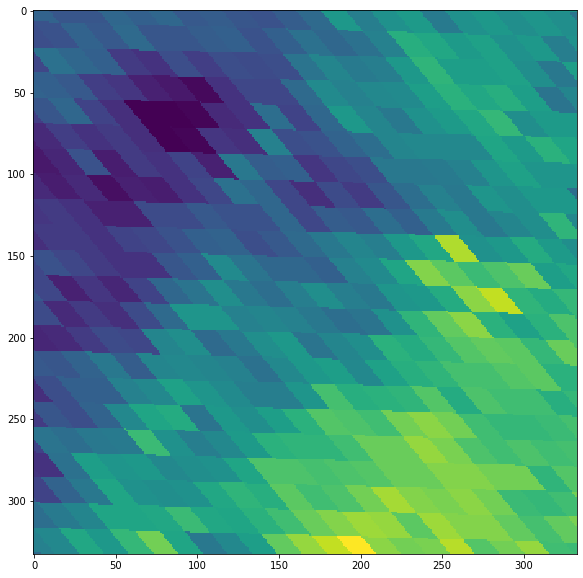

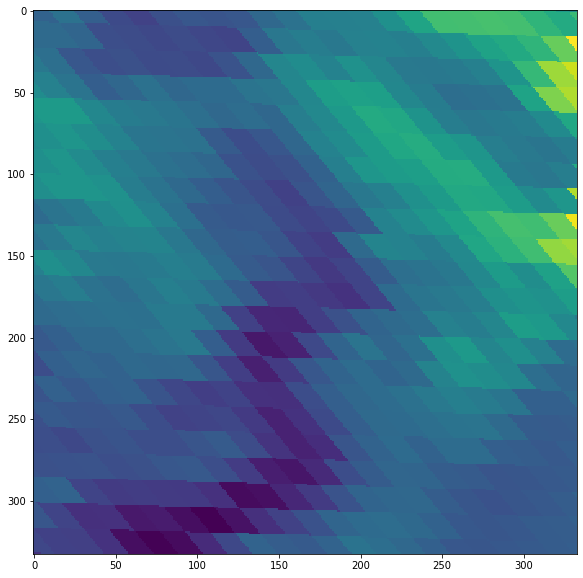

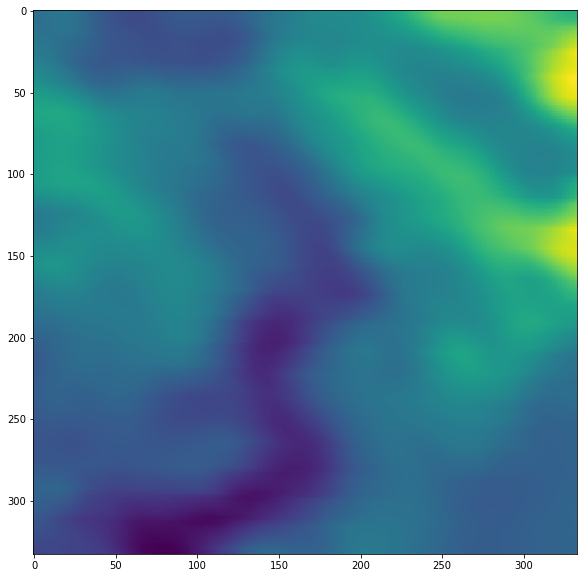

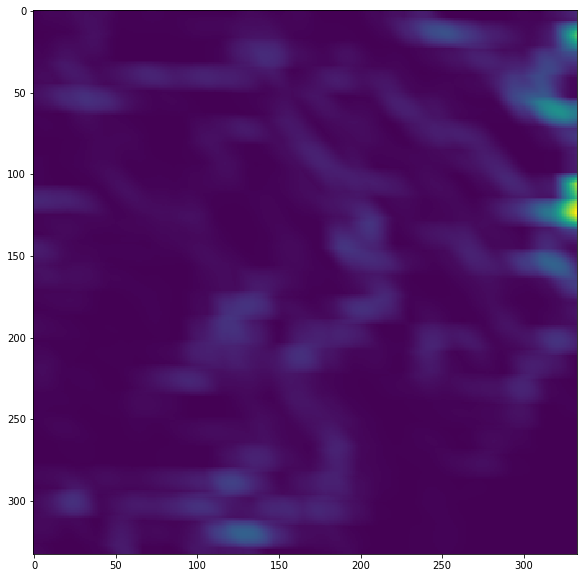

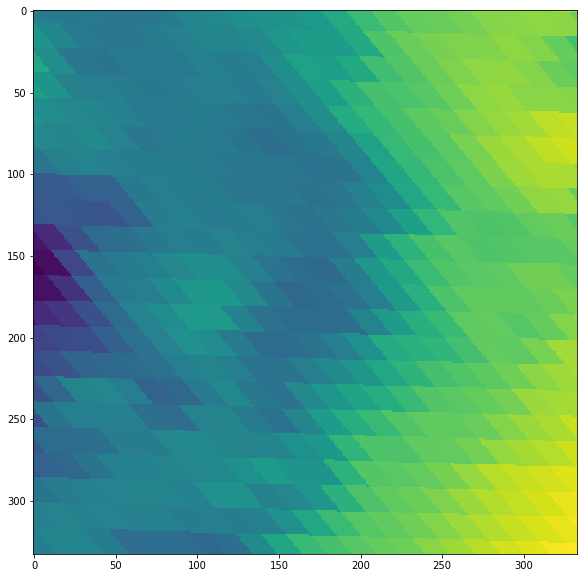

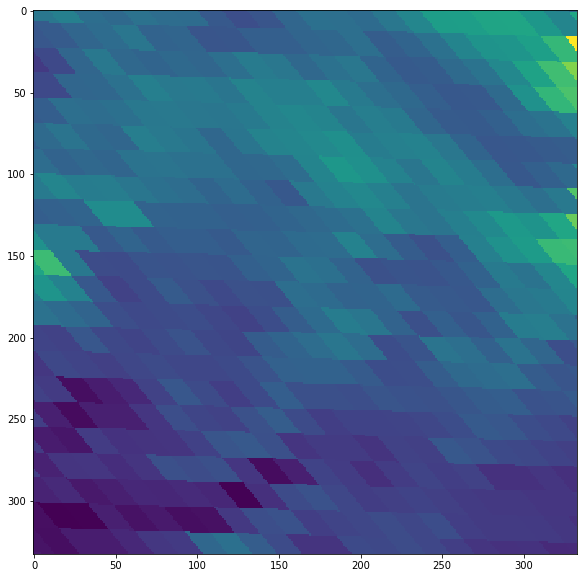

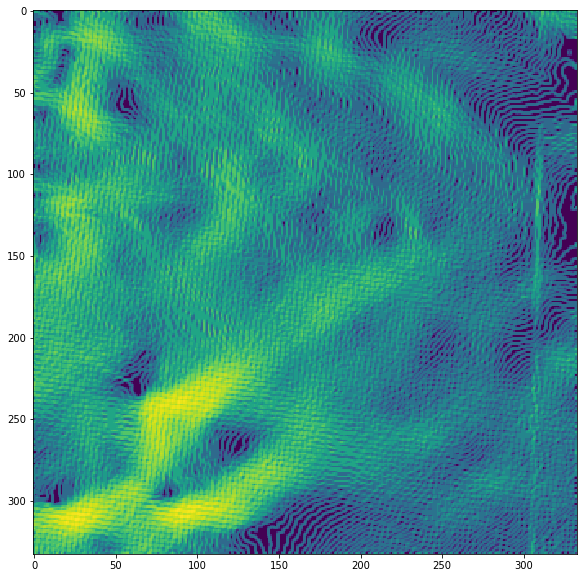

In [39]:
plot_utils.plot_all_bands_in_data_acces_name(eo_patch, data_acces_name='DATASET_RAW_NDWI_NRB_19_NORM_SLOPE', datetime_idx=15)

###  test patch

####  Load model

In [40]:
# uncomment to load the model and replace with your file, usually just correct the date
#model_path = './NEW_model_20000_unbalanced_WATER_only_MODIS_test_7_fixed_lr_01_min_wat_50.pkl'
#model = joblib.load(model_path)

####  Load test eopatch 

In [41]:
# Declare EOPatches

In [42]:
test_eopatches_filenames[-1]

'../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10_sptl_smpl_25k_pr_pic_ref_1_2_min_wat_25/3473_maxcc_0.05_x-7_y-134'

In [43]:
test_eo_patch_filepath = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10/3473_maxcc_0.05_x-7_y-134'

eo_patch_test = EOPatch.load(test_eo_patch_filepath) 
eo_patch_test

EOPatch(
  data: {
    DATASET_CLD_200_dil_6_str2: numpy.ndarray(shape=(28, 333, 333, 11), dtype=float32)
    DATASET_RAW_NDWI_NRB_19_NORM_SLOPE: numpy.ndarray(shape=(28, 333, 333, 13), dtype=float32)
    LANDSAT_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_GREEN_NIR: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_ICE: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_1: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_2: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    LANDSAT_QA_LAYERS: numpy.ndarray(shape=(28, 333, 333, 5), dtype=float32)
    LANDSAT_RAW_BANDS: numpy.ndarray(shape=(28, 333, 333, 11), dtype=float32)
    MODIS_AVG_NBR_19: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(28, 333, 333, 1), dtype=float32)
  

In [44]:
# TASK FOR PREDICTION
predict_patch = PredictPatch(model, (FeatureType.DATA, 'DATASET_RAW_NDWI_NRB_19_NORM_SLOPE'), 'WATER_MASK_ST_025')

predictions_test = []
predictions_test.append(predict_patch.execute(eo_patch_test))

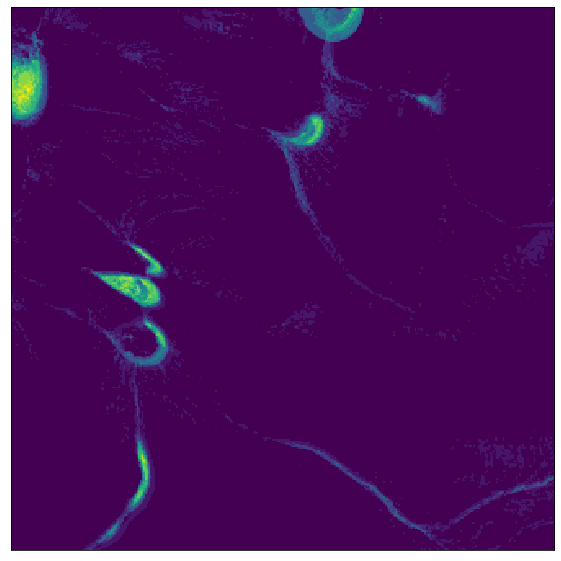

In [45]:
plot_utils.plot_timeless_mask_LANDSAT_8(eo_patch_test, band_idx=0, mask_acces_name='WATER_MASK_ST_025_COUNT' )

2019-07-17 00:01:03
Ploting...


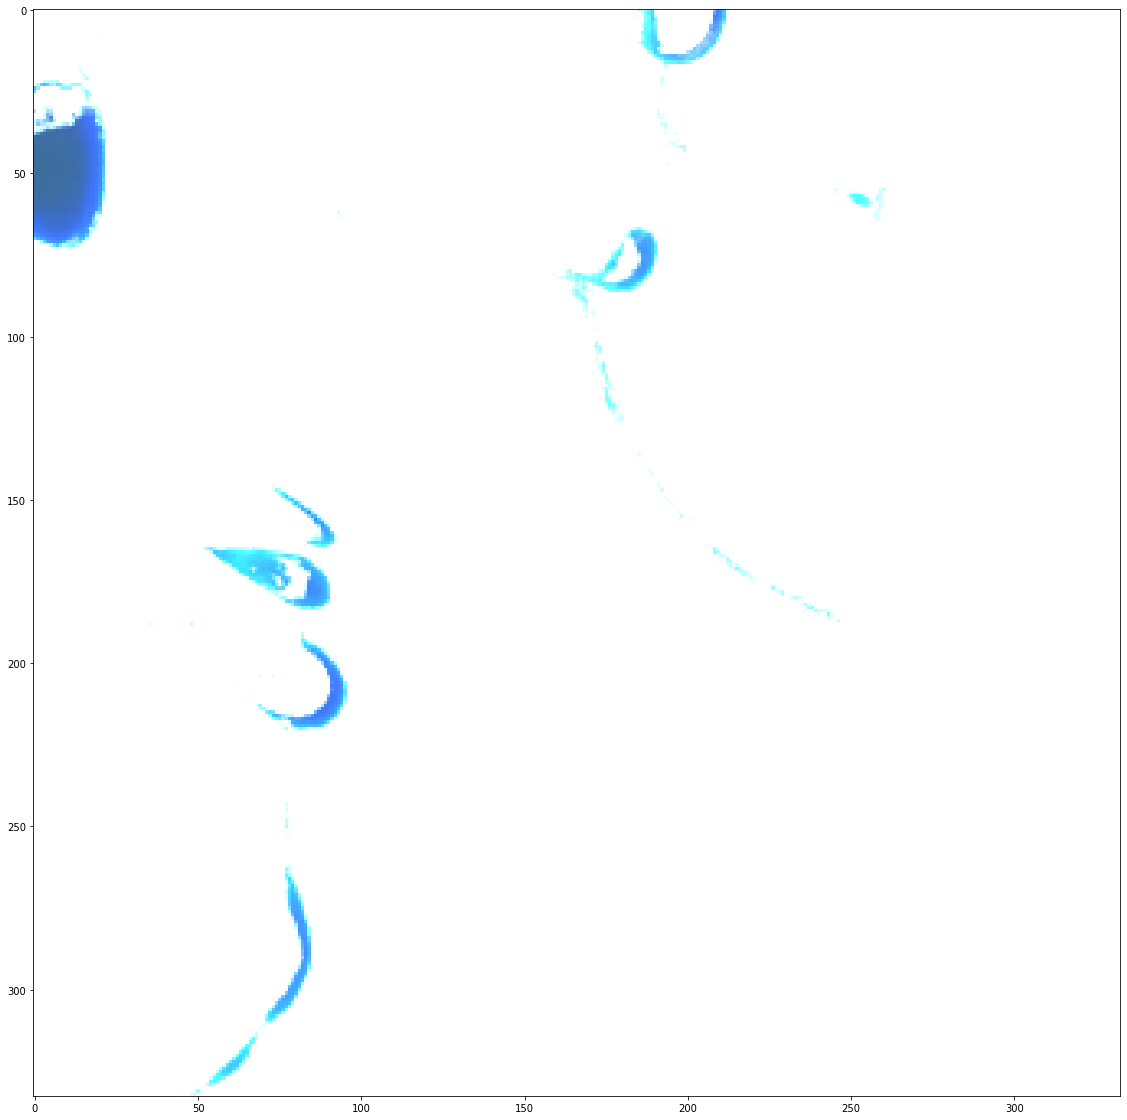

In [46]:
plot_utils.plot_RGB_LANDSAT_8_image(eo_patch_test, datetime_idx=15 )

2019-07-17 00:01:03
Ploting...


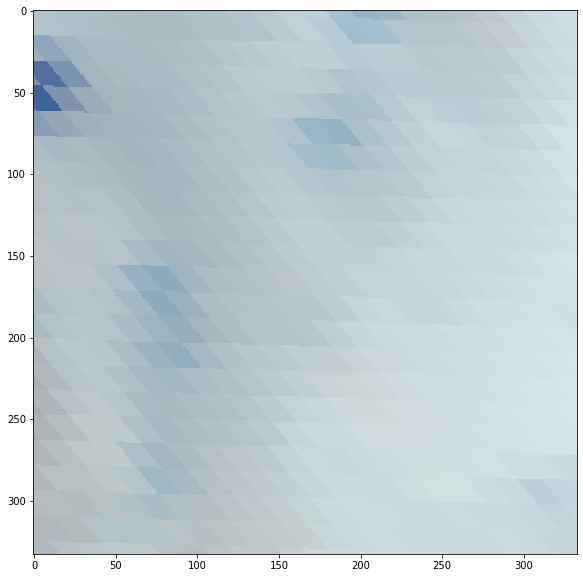

In [47]:
plot_utils.plot_RGB_MODIS_image(eo_patch_test, data_acces_name='MODIS_RAW_BANDS_DAY_0', datetime_idx=15)

In [48]:
patch_no = 15
reference_patch_test = eo_patch_test.mask['WATER_MASK_ST_025'][patch_no]
inspected_patch_test = predictions_test[0][patch_no]

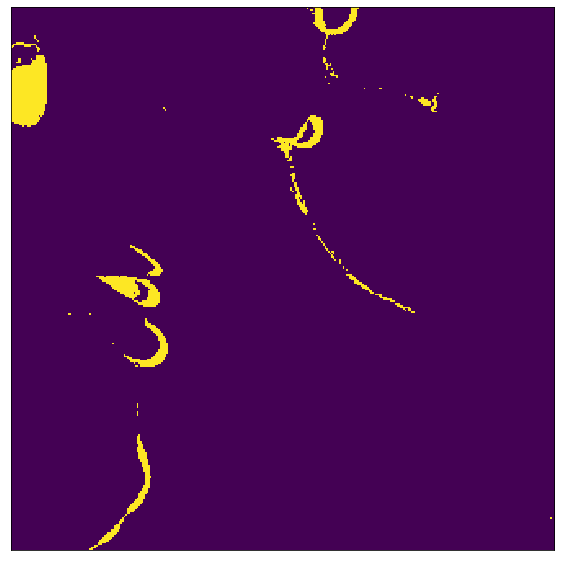

In [49]:
plot_utils.plot_matrix(reference_patch_test)

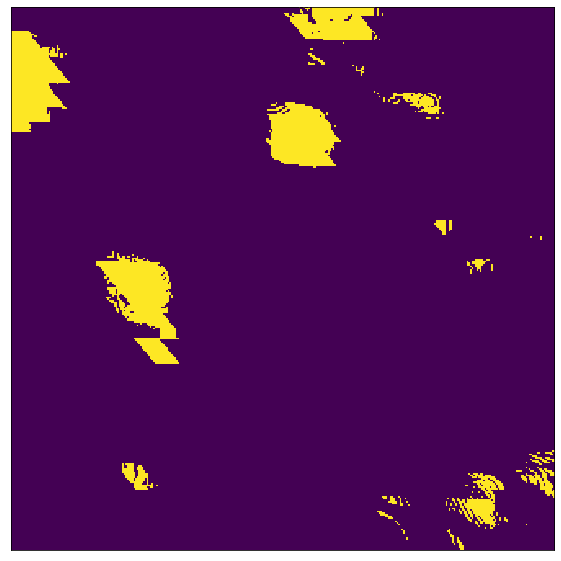

In [50]:
plot_utils.plot_matrix(inspected_patch_test)

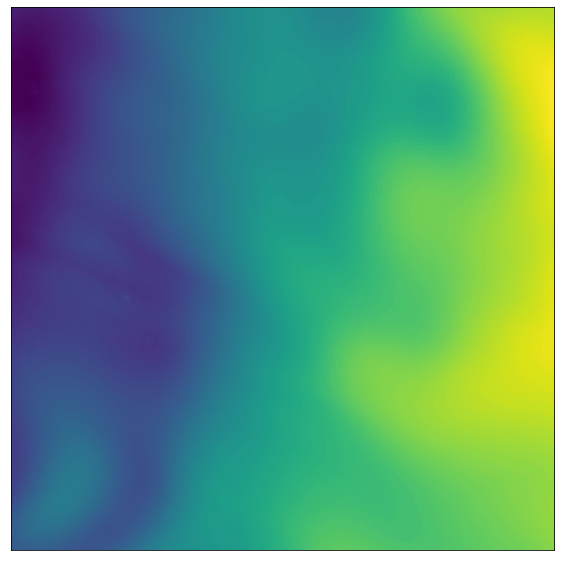

In [51]:
plot_utils.plot_matrix(eo_patch_test.data_timeless['DEM_RAW_LAYER'].squeeze())

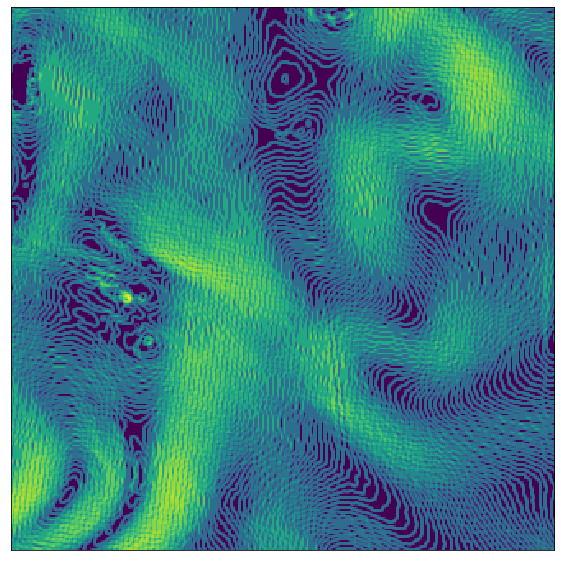

In [52]:
plot_utils.plot_matrix(eo_patch_test.data_timeless['DEM_SLOPE_LAYER'][1:-1,1:-1].squeeze())

In [53]:
water_features = eo_patch_test.mask_timeless['WATER_MASK_ST_025_COUNT']

In [54]:
import matplotlib.pyplot as plt

In [55]:
def plot_two_pictures_on_top_of_each_other(background_picture , mask, alpha):
    
    plt.figure(figsize=(10, 10))
    plt.imshow(background_picture.squeeze(), interpolation='none')
    plt.imshow(mask.squeeze(), interpolation='none', alpha=alpha)
    plt.show()

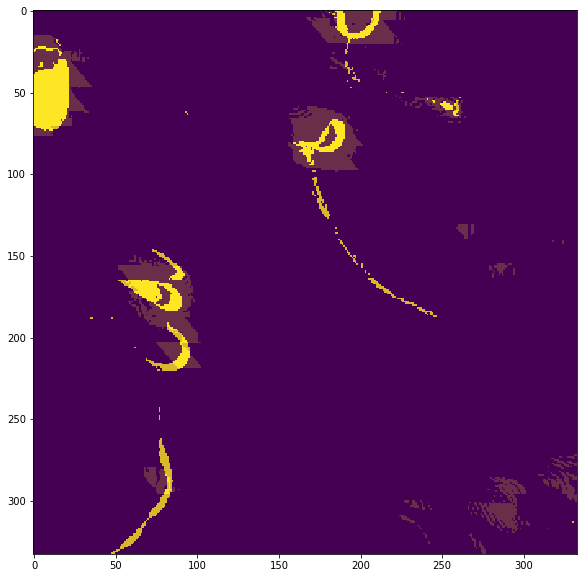

In [56]:
plot_two_pictures_on_top_of_each_other(reference_patch_test, inspected_patch_test, 0.2)

In [57]:
del features_train
del labels_train
del features_test
del labels_test

### Takeout: These model is similar as D5f i g and both of them can be applied to initial result production, this has better recall for water. - kind of better we have to compare it to the previous test dataset:

In [58]:
# pick dataset_name
input_dataset_file_name = '_sptl_smpl_80000_pr_pic_ref_0_1_min_wat_25/'

dataset_filepath_2013 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2013_05-2013_10{}'.format(input_dataset_file_name)
dataset_filepath_2014 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2014_05-2014_10{}'.format(input_dataset_file_name)
dataset_filepath_2015 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2015_05-2015_10{}'.format(input_dataset_file_name)
dataset_filepath_2016 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2016_05-2016_10{}'.format(input_dataset_file_name)
dataset_filepath_2017 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2017_05-2017_10{}'.format(input_dataset_file_name)
dataset_filepath_2018 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2018_05-2018_10{}'.format(input_dataset_file_name)
dataset_filepath_2019 = '../../data/EOPatches/LANDSAT_8/UPE_PROMICE/UTM_22N/2019_05-2019_10{}'.format(input_dataset_file_name)

dataset_path_list = [dataset_filepath_2013,
                dataset_filepath_2014,
                dataset_filepath_2015,
                dataset_filepath_2016,
                dataset_filepath_2017,
                dataset_filepath_2018,
                dataset_filepath_2019]

In [59]:
#list_of_available_patches_2013 = io_utils.get_list_of_eopatches(dataset_filepath_2013)

#test_eppatches_chosen_names = np.random.choice(list_of_available_patches_2013, 7, replace=True)
#test_eppatches_chosen_names

test_eppatches_chosen_names = np.array(['2974_maxcc_0.05_x-3_y-135', '2976_maxcc_0.05_x-3_y-137',
       '3179_maxcc_0.05_x-5_y-137', '3067_maxcc_0.05_x-4_y-138',
       '3180_maxcc_0.05_x-5_y-138', '3473_maxcc_0.05_x-7_y-134',
       '2975_maxcc_0.05_x-3_y-136'], dtype='<U25')


In [60]:
%%time
train_eopatches= []
test_eopatches= []
train_eopatches_filenames = []
test_eopatches_filenames = []

for eopatches_filepath in dataset_path_list:

    list_of_available_patches = io_utils.get_list_of_eopatches(eopatches_filepath)
    list_in_chunks = io_utils.chunkIt(list_of_available_patches, 2 ) # number of chunks- 1 bc all can go
    for chunk in list_in_chunks:
        #print('Doing now following eopatches:', chunk )
        for eopatch_name in chunk:
            if eopatch_name in test_eppatches_chosen_names:
                test_eopatches_filenames.append(eopatches_filepath+eopatch_name)
                test_eopatches.append(EOPatch.load(eopatches_filepath+eopatch_name, lazy_loading=True))
                
            else:
                train_eopatches_filenames.append(eopatches_filepath+eopatch_name)
                train_eopatches.append(EOPatch.load(eopatches_filepath+eopatch_name, lazy_loading=True))    
print(len(train_eopatches))
print(len(test_eopatches))

221
46
Wall time: 4.43 s


In [61]:
# Definition of the train and test patch IDs

# Set the features and the labels for train and test sets
features_train_cmp = np.array([eopatch.data['DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED'] for eopatch in train_eopatches if eopatch.data['DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED'].size > 0])
#features_train (number_of_patches,(time,width,height, bands))
labels_train_cmp = np.array([eopatch.mask['WATER_MASK_ST_025_SAMPLED'] for eopatch in train_eopatches if eopatch.mask['WATER_MASK_ST_025_SAMPLED'].size > 0])
#features_train (number_of_patches,(time,width,height, answer=True, False))
features_test_cmp = np.array([eopatch.data['DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED'] for eopatch in test_eopatches if eopatch.data['DATASET_RAW_NDWI_NRB_19_NORM_SLOPE_SAMPLED'].size > 0 ])
labels_test_cmp = np.array([eopatch.mask['WATER_MASK_ST_025_SAMPLED'] for eopatch in test_eopatches if eopatch.mask['WATER_MASK_ST_025_SAMPLED'].size > 0])

In [62]:
#reshape to  (number_of_patches x time, width, height, bands)
features_train_stacked = np.vstack(features_train_cmp)
labels_train_stacked = np.vstack(labels_train_cmp)
features_test_stacked = np.vstack(features_test_cmp)
labels_test_stacked = np.vstack(labels_test_cmp)

# get shape
p_train_x_time, w, h, b = features_train_stacked.shape
p_test_x_time, w, h, b = features_test_stacked.shape


# reshape to n x m
#n - no of observation
#m - no of features, - bands in my case, misssing DEM

features_train_cmp = features_train_stacked.reshape(p_train_x_time * w * h, b)
labels_train_cmp = labels_train_stacked.reshape(p_train_x_time * w * h, 1)
features_test_cmp = features_test_stacked.reshape(p_test_x_time * w * h, b)
labels_test_cmp = labels_test_stacked.reshape(p_test_x_time * w * h, 1)


#@TODO
# remove points with no reference from training (so we dont train to recognize "no data")
# interpolation????
#mask_train = labels_train == 0
#features_train = features_train[~mask_train]
#labels_train = labels_train[~mask_train]

# remove points with no reference from test (so we dont validate on "no data", which doesn't make sense)
#mask_test = labels_test == 0
#features_test = features_test[~mask_test]
#labels_test = labels_test[~mask_test]


In [63]:
#to compare old data distribution (little less )

print('TRAIN DATA:')
tot_obs = np.size(labels_train_cmp)
print('Total observations: ', tot_obs )

tot_wat = np.count_nonzero(labels_train_cmp)
print('Total water count', tot_wat )

ratio_wat_vs_non_wat = tot_wat/ tot_obs
print('Percent of water feature among data:', ratio_wat_vs_non_wat )

print('\nTEST DATA:')

tot_obs = np.size(labels_test_cmp)
print('Total observations: ', tot_obs )

tot_wat = np.count_nonzero(labels_test_cmp)
print('Total water count', tot_wat )

ratio_wat_vs_non_wat = tot_wat/ tot_obs
print('Percent of water feature among data:', ratio_wat_vs_non_wat )
# dataset is half of the previous one!!!

TRAIN DATA:
Total observations:  121200000
Total water count 2400932
Percent of water feature among data: 0.0198096699669967

TEST DATA:
Total observations:  27280000
Total water count 772016
Percent of water feature among data: 0.028299706744868036


In [64]:
print('TRAIN')
# predict the train labels
plabels_train_cmp = model.predict(features_train_cmp)

print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_train_cmp, plabels_train_cmp)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_train_cmp, plabels_train_cmp, average='weighted')))

TRAIN
Classification accuracy 97.3%
Classification F1-score 97.3%


In [65]:
# predict the test labels
print('TEST')
plabels_test_cmp = model.predict(features_test_cmp)
print('Classification accuracy {:.1f}%'.format(100 * metrics.accuracy_score(labels_test_cmp, plabels_test_cmp)))
print('Classification F1-score {:.1f}%'.format(100 * metrics.f1_score(labels_test_cmp, plabels_test_cmp, average='weighted')))

TEST
Classification accuracy 96.7%
Classification F1-score 96.4%


In [66]:
actual_water_cmp = np.count_nonzero(labels_test_cmp)
predicted_water_cmp = np.count_nonzero(plabels_test_cmp)

print('Water Test data size:',actual_water_cmp)

tp_cmp = np.count_nonzero(np.logical_and(labels_test_cmp.squeeze(), plabels_test_cmp.squeeze()))
print('Water True positive:', tp_cmp, 'and recall', 100* tp_cmp /actual_water_cmp, 'and precision:', tp_cmp /predicted_water_cmp)

Water Test data size: 772016
Water True positive: 217382 and recall 28.15770657602951 and precision: 0.3861157341868607


In [67]:
class_labels = np.unique(labels_test_cmp)
print(class_labels)
class_names = ['non-water', 'water']
class_names

[False  True]


['non-water', 'water']

In [68]:

f1_scores = metrics.f1_score(labels_test_cmp, plabels_test_cmp, labels=class_labels, average=None)
recall = metrics.recall_score(labels_test_cmp, plabels_test_cmp, labels=class_labels, average=None)
precision = metrics.precision_score(labels_test_cmp, plabels_test_cmp, labels=class_labels, average=None) 

print('             Class              =  F1  | Recall | Precision')
print('         --------------------------------------------------')
for idx, lulctype in enumerate([class_names[idx] for idx in class_labels]):
    print('         * {0:20s} = {1:2.1f}% |  {2:2.1f}%  | {3:2.1f}%'.format(lulctype, 
                                                                         f1_scores[idx] * 100, 
                                                                         recall[idx] * 100, 
                                                                         precision[idx] * 100))

             Class              =  F1  | Recall | Precision
         --------------------------------------------------


C:\Users\Kamil\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  import sys


         * non-water            = 98.3% |  98.7%  | 97.9%
         * water                = 32.6% |  28.2%  | 38.6%
